<h1 align=center><font size=5>4. Machine Learning con Python, transacciones fraudulentas.</font></h1>
<h1 align=center><font size=3>Innovation Lab, IBM Uruguay</font></h1>

El objetivo de este notebook es estudiar un ejemplo simple de __Machine Learning para detectar fraudes en transacciones__ aplicando algunas de las técnincas de análisis y visualización de datos del notebook 3. 

Se tiene una base de datos con información sobre las transacciones en un sitio de e-commerce que vende ropa de segunda mano. Dentro de esa base de datos, se tiene un _feature_ que indica si el usuario involucrado en una compra participó en actividades fraudulentas (ej: usando los datos de la tarjeta de crédito de un tercero.). 

Se construirá un modelo que intentará predecir qué comportamientos son "normales". Para los usuarios fraudulentos, algunas de las características tienen valores inusuales. En particular, veremos que hay comportamientos que delatan el fraude:
- Un ip/dispositivo con muchos usuarios asociados.
- Tiempo desde el sign-up hasta la compra sospechosamente corto. 

__Metas concretas:__
- Determinar que carcterísticas de las transacciones influyen en la probabilidad de que un usuario sea fraudulento.
- Construir un modelo con árboles de decisión teniendo en cuenta el costo de los falsos positivos y falsos negativos.
- Entender dicho modelo, __¿Cuando acierta? ¿Por qué?__


## 1. Introducción 

In [1]:
# Analisis
import numpy as np
import pandas as pd
from scipy import special
from random import sample

# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Construcción de modelos
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

#Score del mdelo
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import f1_score

#Otros
import itertools
from datetime import timedelta
from IPython.display import display

pd.options.display.max_seq_items = 2000

In [2]:
#Base de datos
fraud_df = pd.read_csv("Fraud_Data/Fraud_Data_with_Countries.csv", header=0)

### 1.1 Exploración de los datos 

Comencemos por preguntas simples, ¿Qué __tipos__ de variables están presentes?

In [3]:
fraud_df.dtypes

user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
country            object
dtype: object

In [4]:
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Missing
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [5]:
fraud_df.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


Al igual que en el notebook 3, debemos fijarnos si hay __entradas faltantes__ y en caso afirmativo decidir qué hacer con ellas (eliminarlas o estimarlas).

In [6]:
missing_data = fraud_df.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")  

user_id
False    151112
Name: user_id, dtype: int64

signup_time
False    151112
Name: signup_time, dtype: int64

purchase_time
False    151112
Name: purchase_time, dtype: int64

purchase_value
False    151112
Name: purchase_value, dtype: int64

device_id
False    151112
Name: device_id, dtype: int64

source
False    151112
Name: source, dtype: int64

browser
False    151112
Name: browser, dtype: int64

sex
False    151112
Name: sex, dtype: int64

age
False    151112
Name: age, dtype: int64

ip_address
False    151112
Name: ip_address, dtype: int64

class
False    151112
Name: class, dtype: int64

country
False    151112
Name: country, dtype: int64



Por lo tanto, no hay datos faltantes (probablemente, estos hayan sido eliminados previamente).

<h2><font size=3>1.2 Visualizazión de los datos </font></h2>

Estas visualizaciones nos ayudarán a entender la relación entre las distintas variables.

__1.2.1 ¿El sexo del usuario influye?__

Text(0, 0.5, 'Counts')

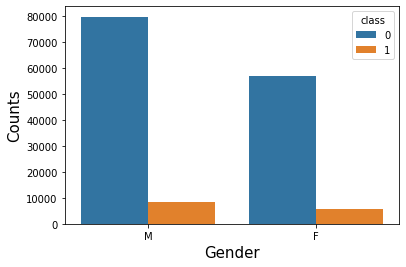

In [7]:
sns.countplot(x='sex', hue='class', data=fraud_df)
plt.xlabel("Gender", fontsize=15)
plt.ylabel("Counts", fontsize=15)

Se puede observar que hay más fraudes cometidos por hombres que por mujeres. Sin embargo, __no debemos apresurarnos__ a sacar conclusiones ya que también hay más usuarios hombres en la base de datos.

Para refinar nuestro análisis debemos calcular la proporción de hombres y mujeres que cometen fraudes.

In [8]:
fraud_df["sex"].value_counts()

M    88293
F    62819
Name: sex, dtype: int64

In [9]:
fraud_df.groupby("sex")["class"].describe()

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
F,62819.0,0.091007,0.287622,0.0,0.0,0.0,0.0,1.0
M,88293.0,0.095523,0.293937,0.0,0.0,0.0,0.0,1.0


Observando el campo __mean__ (proporción de hombres y mujeres fraudulentos) vemos que: __no hay diferencias significativas entre la proporción de hombres y mujeres que cometen fraudes__. Por lo tanto, este feature no se va a poder usar para estimar la probabilidad de que un usuario cometa fraudes.

__1.2.2 ¿El valor de la compra influye?__

c:\users\juanelenter\appdata\local\programs\python\python37-32\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


Text(0.42499999999999716, 0.5, 'Purchase Value')

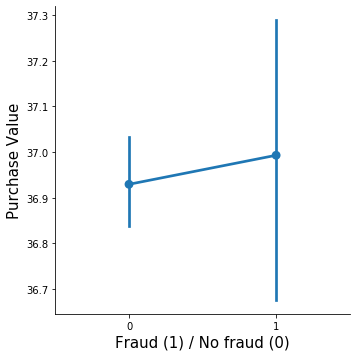

In [10]:
sns.factorplot(x="class", y="purchase_value", data=fraud_df)
plt.xlabel("Fraud (1) / No fraud (0)", fontsize=15)
plt.ylabel("Purchase Value", fontsize=15)

In [11]:
diferencia_de_promedios = fraud_df[fraud_df["class"] == 1]["purchase_value"].mean()-fraud_df[fraud_df["class"] == 0]["purchase_value"].mean()
print(f"La diferencia entre promedios es de {diferencia_de_promedios}")

La diferencia entre promedios es de 0.06358616450449972


La diferencia entre los promedios de las compras de usuarios fraudulentos y no fraudulentos es muy pequeña. Además, los rangos de estos valores se superponen significativamente. 

Por estas dos razones, __no utilizaremos el valor de compra__ cómo un estimador.

__1.2.3 ¿La supuesta edad del usuario influye?__

Text(-5.825000000000003, 0.5, 'Age')

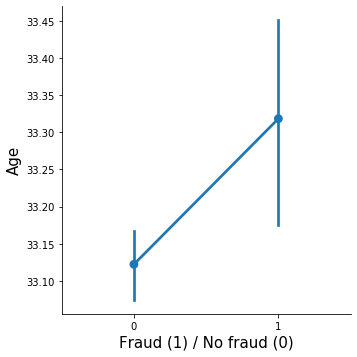

In [12]:
sns.factorplot(x="class", y="age", data=fraud_df)
plt.xlabel("Fraud (1) / No fraud (0)", fontsize=15)
plt.ylabel("Age", fontsize=15)

In [13]:
diferencia_de_promedios = fraud_df[fraud_df["class"] == 1]["age"].mean()-fraud_df[fraud_df["class"] == 0]["age"].mean()
print(f"La diferencia entre promedios es de {abs(diferencia_de_promedios)}")

La diferencia entre promedios es de 0.19592539438804835


En este caso, si bien los rangos no están tan solapados, la diferencia de promedios es muy pequeña, por lo que no será utilizado cómo un estimador.

__1.2.4 Navegador__

Text(0, 0.5, 'Counts')

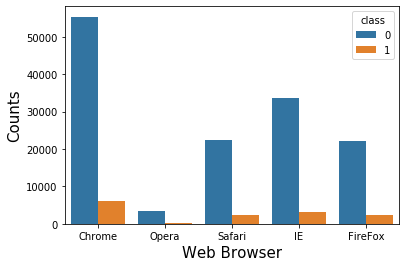

In [14]:
sns.countplot(x='browser', hue='class', data=fraud_df)
plt.xlabel("Web Browser", fontsize=15)
plt.ylabel("Counts", fontsize=15)

Este caso es similar al del sexo del usuario. Hay muchos más usuarios fraudulentos que utilizan Chrome que Opera, pero observando el histograma podemos deducir que esto se debe a que simplemente hay más usuarios que utilizan Chrom que Opera.

Observemos las proporciones:

In [15]:
fraud_df.groupby("browser")["class"].describe()

,count,mean,std,min,25%,50%,75%,max
browser,,,,,,,,
Chrome,61432.0,0.098792,0.298385,0.0,0.0,0.0,0.0,1.0
FireFox,24610.0,0.095165,0.293448,0.0,0.0,0.0,0.0,1.0
IE,36727.0,0.086775,0.281509,0.0,0.0,0.0,0.0,1.0
Opera,3676.0,0.089227,0.285111,0.0,0.0,0.0,0.0,1.0
Safari,24667.0,0.090201,0.286476,0.0,0.0,0.0,0.0,1.0


Es claro que este no será un buen indicador de peligro de fraude.

__1.2.5 País de origen__

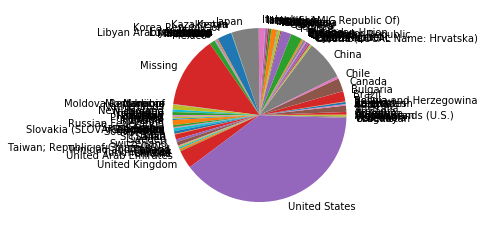

In [16]:
sums = fraud_df[fraud_df["class"] == 1]["class"].groupby(fraud_df.country).sum()
plt.axis('equal')
plt.pie(sums, labels=sums.index)
plt.show()

Resulta complejo representar todos los países gráficamente (son más de 200). Sin embargo, el __pie chart__ permite ver que países contribuyen en más proporción a los fraudes. 

In [17]:
fraudes_paises = fraud_df["class"].groupby(fraud_df.country).sum()
#sns.countplot(x='country', hue='class', data=fraud_df)
fraud_df["class"].groupby(fraud_df.country).sum().sort_values()

country
Kyrgyzstan           0
Maldives             0
Madagascar           0
Macau                0
Liechtenstein        0
                  ... 
United Kingdom     477
Japan              715
China             1043
Missing           1883
United States     5551
Name: class, Length: 182, dtype: int64

In [18]:
paises_totales = fraud_df["country"].value_counts()
fraud_df["country"].value_counts()

United States     58049
Missing           21966
China             12038
Japan              7306
United Kingdom     4490
                  ...  
Dominica              1
Cape Verde            1
South Sudan           1
Gambia                1
Tajikistan            1
Name: country, Length: 182, dtype: int64

In [19]:
for p in ["United States", "China", "Missing", "Bulgaria", "San Marino"]:
    print(p, fraudes_paises[p]/paises_totales[p])

United States 0.09562610897689883
China 0.08664229938527995
Missing 0.08572339069471001
Bulgaria 0.012048192771084338
San Marino 0.0


__1.2.6 Cantidad de usuarios asociados al mismo dispositivo o IP__

Crearemos un nuevo data frame para estudiar la cantidad de usuarios asociados al mismo dispositivo o IP ya que este será uno de los indicadores fundamentales que utilziramos para construir el árbol de decisión.

Text(16.299999999999997, 0.5, 'User ids per IP Address')

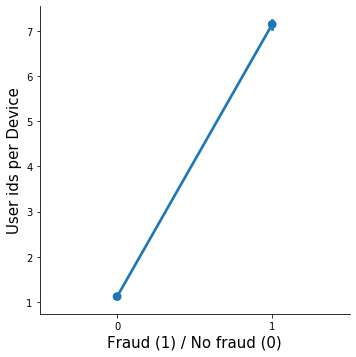

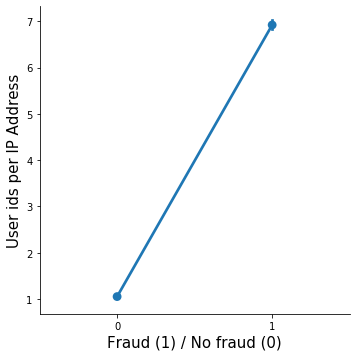

In [20]:

tmp_df = pd.DataFrame(columns=("class", "userids_per_deviceid", "userids_per_ipaddress"))
tmp_df["class"] = fraud_df["class"]

# Contamos el numero de dispositivos asociados a cada usuario
userid_count = fraud_df.groupby("device_id").user_id.count()
tmp_df["userids_per_deviceid"] = fraud_df.device_id.apply(lambda x: userid_count[x])

# Contamos el numero de IPs asociadas a cada usuario
userid_count = fraud_df.groupby("ip_address").user_id.count()
tmp_df["userids_per_ipaddress"] = fraud_df.ip_address.apply(lambda x: userid_count[x])

sns.factorplot(x="class", y="userids_per_deviceid", data=tmp_df)
plt.xlabel("Fraud (1) / No fraud (0)", fontsize=15)
plt.ylabel("User ids per Device", fontsize=15)

sns.factorplot(x="class", y="userids_per_ipaddress", data=tmp_df)
plt.xlabel("Fraud (1) / No fraud (0)", fontsize=15)
plt.ylabel("User ids per IP Address", fontsize=15)

__1.2.7 ¿El tiempo entre sign up y compra influye?__

Text(-8.825000000000003, 0.5, 'Sign-up to Purchase Time (Seconds)')

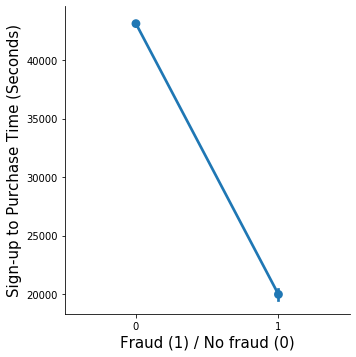

In [21]:
# Convert sign-up time and purchase time to datetime objects
tmp_df["signup_time"] = fraud_df.signup_time.apply(pd.to_datetime)
tmp_df["purchase_time"] = fraud_df.purchase_time.apply(pd.to_datetime)

# Add columns for the number of seconds between purchase and sign-up times
tmp_df["signup_to_purchase_seconds"] = (tmp_df.purchase_time - tmp_df.signup_time).apply(lambda x: x.seconds)

sns.factorplot(x="class", y="signup_to_purchase_seconds", data=tmp_df)
plt.xlabel("Fraud (1) / No fraud (0)", fontsize=15)
plt.ylabel("Sign-up to Purchase Time (Seconds)", fontsize=15)

__1.2.8 ¿El momento (hora, día, semana) influye?__

Text(0, 0.5, 'Count')

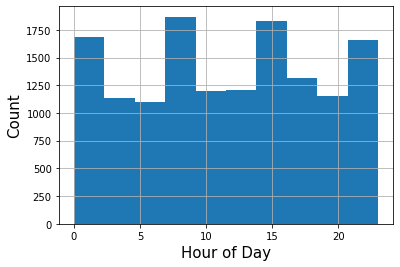

In [22]:
tmp_df[tmp_df["class"] == 1].signup_time.apply(lambda x: x.hour).hist()
plt.xlabel("Hour of Day", fontsize=15)
plt.ylabel("Count", fontsize=15)

Text(0, 0.5, 'Count')

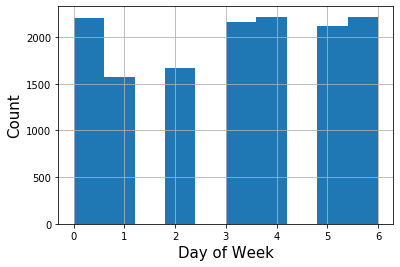

In [23]:
tmp_df[tmp_df["class"] == 1].signup_time.apply(lambda x: x.dayofweek).hist()
plt.xlabel("Day of Week", fontsize=15)
plt.ylabel("Count", fontsize=15)

Text(0, 0.5, 'Count')

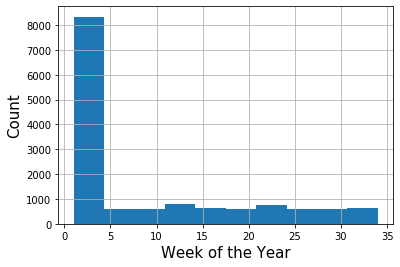

In [24]:
tmp_df[tmp_df["class"] == 1].signup_time.apply(lambda x: x.week).hist()
plt.xlabel("Week of the Year", fontsize=15)
plt.ylabel("Count", fontsize=15)

## 2. Ingeniería de características

### 2.1 Setup del data frame.
En esta sección crearemos un nuevo data frame en el cual incluiremos una versión modificada de las características elegidas en la sección anterior.
Las modificaciones de estas características tienen cómo objetivo construir un modelo más preciso.

Utilizaremos: 

    - Cantidad de usuarios por dispositivo/IP (unidos en un sólo feature).
    - Tiempo entre sign up y compra.
    - "One-Hot-Encoding" features para cada país.

In [33]:
# Para evitar errores, volvemos a cargar el df.
fraud_df = pd.read_csv("Fraud_Data/Fraud_Data_with_Countries.csv", header=0)

# Agrego columna con el numero de user ids asociados a un device id
userid_count = fraud_df.groupby("device_id").user_id.count()
fraud_df["userids_per_deviceid"] = fraud_df.device_id.apply(lambda x: userid_count[x])

# Agrego columna con el numero de user ids asociados a cada ip
userid_count = fraud_df.groupby("ip_address").user_id.count()
fraud_df["userids_per_ipaddress"] = fraud_df.ip_address.apply(lambda x: userid_count[x])

# Utilizaremos el promedio de estas dos columnas cómo único feature
fraud_df["mean_number_of_userids"] = (fraud_df.userids_per_deviceid + fraud_df.userids_per_ipaddress) * 0.5

# Formateo de tiempos
fraud_df.signup_time = fraud_df.signup_time.apply(pd.to_datetime)
fraud_df.purchase_time = fraud_df.purchase_time.apply(pd.to_datetime)

# Agrego columnas con tiempo de compra en segundos
fraud_df["signup_to_purchase_seconds"] = (fraud_df.purchase_time - fraud_df.signup_time).apply(lambda x: x.seconds)

# Creamos "dummy columns" para usar esta variable categorica cómo predictor.
country_dummies = pd.get_dummies(fraud_df.country, prefix='country')
fraud_df = pd.concat([fraud_df, country_dummies], axis=1)

#Eliminamos las columnas que no utilizaremos
fraud_df.drop(["user_id", 
               "signup_time", 
               "purchase_time", 
               "device_id", 
               "ip_address", 
               "userids_per_deviceid",
               "userids_per_ipaddress",
               "country",
               "source",
               "browser",
               "sex",
               "age",
               "purchase_value"
               ], axis=1, inplace=True)

In [26]:
fraud_df.head(10)

,class,mean_number_of_userids,signup_to_purchase_seconds,country_Afghanistan,country_Albania,country_Algeria,country_Angola,country_Antigua and Barbuda,country_Argentina,country_Armenia,...,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
0,0,1.0,13882,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1.0,17944,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1,12.0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,1.0,60085,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1.0,41461,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
5,0,1.0,7331,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,1.0,17825,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,1.0,35129,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
8,0,1.0,51800,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,1.0,18953,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [27]:
fraud_df.describe()

,class,mean_number_of_userids,signup_to_purchase_seconds,country_Afghanistan,country_Albania,country_Algeria,country_Angola,country_Antigua and Barbuda,country_Argentina,country_Armenia,...,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
count,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,...,151112.000000,151112.000000,151112.000000,151112.000000,151112.000000,151112.00000,151112.000000,151112.000000,151112.000000,151112.000000
mean,0.093646,1.643543,40942.584427,0.000040,0.000086,0.000807,0.000159,0.000020,0.004374,0.000099,...,0.384146,0.000529,0.000066,0.000007,0.001661,0.00364,0.000020,0.000007,0.000066,0.000040
std,0.291336,2.600779,26049.661902,0.006301,0.009275,0.028402,0.012602,0.004456,0.065993,0.009963,...,0.486394,0.023003,0.008135,0.002572,0.040722,0.06022,0.004456,0.002572,0.008135,0.006301
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,18100.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,40874.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,63504.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,1.000000,20.000000,86399.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


### 2.2 Normalización

Text(0, 0.5, 'Normalized Count')

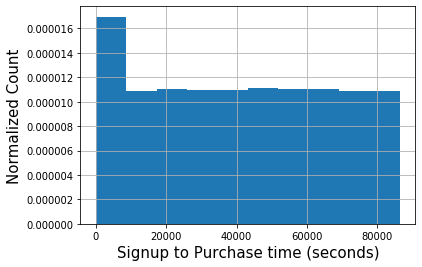

In [40]:
fraud_df.signup_to_purchase_seconds.hist(normed = True, bins=10)
plt.xlabel("Signup to Purchase time (seconds)", fontsize=15)
plt.ylabel("Normalized Count", fontsize=15)

Se puede observar que el tiempo de sign up a compra esta distruibido uniformemente. Para un entrenamiento más preciso, es conveniente __Normalizar__ los datos.

c:\users\juanelenter\appdata\local\programs\python\python37-32\lib\site-packages\pandas\plotting\_matplotlib\hist.py:316: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


Text(0, 0.5, 'Normalized Count')

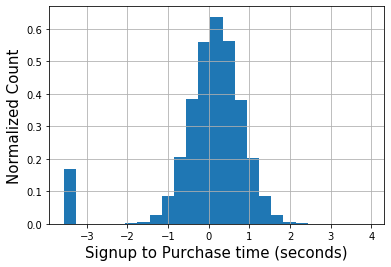

In [57]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
fraud_df["signup_to_purchase_time"] = scaler.fit_transform(fraud_df[["signup_to_purchase_time"]])

fraud_df["signup_to_purchase_time"].hist(normed=True, bins=25)
plt.xlabel("Signup to Purchase time (seconds)", fontsize=15)
plt.ylabel("Normalized Count", fontsize=15)

In [53]:
fraud_df.head()

,class,mean_number_of_userids,country_Afghanistan,country_Albania,country_Algeria,country_Angola,country_Antigua and Barbuda,country_Argentina,country_Armenia,country_Australia,...,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe,signup_to_purchase_time
0,0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.395306
1,0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.290590
2,1,12.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-3.554604
3,0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.492755
4,0,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.160830


In [61]:

non_onehotencoded_cols = [feature for feature in fraud_df.columns if "country" not in feature and feature != "class"]

# Reescalado de 0 a 1
scalermm = MinMaxScaler()
fraud_df["signup_to_purchase_time"] = scalermm.fit_transform(fraud_df[["signup_to_purchase_time"]])
fraud_df["mean_number_of_userids"] = scalermm.fit_transform(fraud_df[["mean_number_of_userids"]])

X = fraud_df[ [col for col in fraud_df.columns if col != "class"] ]
Y = fraud_df["class"]

In [62]:
# Creamos y entrenamos el clasificador
clf = ExtraTreesClassifier(n_estimators=200)
_ = clf.fit(X, Y)

# Veamos el resultado del clasificador, que features fueron determinantes.
features = pd.DataFrame()
features['feature'] = X.columns
features['importance'] = clf.feature_importances_

features[ features.importance > np.mean(features.importance) ].sort_values(by='importance', ascending=False)

,feature,importance
183,signup_to_purchase_time,0.712282
0,mean_number_of_userids,0.282473
